# DESAFIO NPL COM RN

In [2]:
"""Carregando as bibliotecas para desenvolvimento do estudo"""

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SpatialDropout1D , Dropout , Conv1D , MaxPooling1D, Reshape
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## 3 passos basicos 

- Análise de dados
- Preparação do texto
- Algoritmo e Teste


## Análise de dados

In [5]:
data = pd.read_csv('Corona_NLP_train.csv', engine ='python')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
tweet = data[['Sentiment' , 'OriginalTweet']]

In [9]:
tweet.head()

,Sentiment,OriginalTweet
0,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,Positive,advice Talk to your neighbours family to excha...
2,Positive,Coronavirus Australia: Woolworths to give elde...
3,Positive,My food stock is not the only one which is emp...
4,Extremely Negative,"Me, ready to go at supermarket during the #COV..."


In [10]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      41157 non-null  object
 1   OriginalTweet  41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


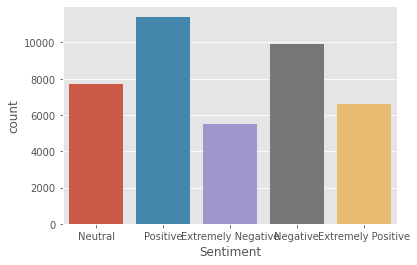

In [11]:
sns.countplot(x = 'Sentiment' , data = tweet)
plt.show()

In [13]:
tweet['OriginalTweet']

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know its getting tough when @KameronWilds...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

In [15]:
sentence = [tweet['OriginalTweet'][2] , tweet['OriginalTweet'][13870]]
sentence

['Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
 'Govt fixes prices of mask and sanitisers Much appreciated decision 19']

## Preparação do texto

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [20]:
def cleanText(OriginalTweet):
    regx_clean = " ".join([re.sub(r'^@[a-zA-z]*' , "" , i) for i in OriginalTweet.split()])
    http_clean = " ".join([word for word in regx_clean.split() if 'http' not in word and word != 'RT'])
    tokens_ = word_tokenize(http_clean)
    words_ = [word for word in tokens_ if word.isalpha()]
    words_ = [w.lower() for w in words_]
#     stop_words = set(stopwords.words('english'))
#     remove_stop = [w for w in words_ if not w in stop_words]
    reformed = [appos[word] if word in appos else word for word in words_]
#     porter = PorterStemmer()
    porter = SnowballStemmer("english")
    stemmed = " ".join([porter.stem(word) for word in reformed])
    return stemmed
print(cleanText("@VirginAmerica What? @dhepburn! said i. 9124 , http.//hiSatyam"))

what said i


In [21]:
text_data = tweet['OriginalTweet']
text_label = tweet['Sentiment']

In [22]:
Lbl = LabelEncoder()
y = Lbl.fit_transform(text_label)

In [23]:
y = to_categorical(y)

In [24]:
X = []
for items in text_data:
    X.append(cleanText(items))

In [29]:
X[:20]

['and and',
 'advic talk to your neighbour famili to exchang phone number creat contact list with phone number of neighbour school employ chemist gp set up onlin shop account if poss adequ suppli of regular med but not over order',
 'coronavirus australia woolworth to give elder disabl dedic shop hour amid outbreak',
 'my food stock is not the onli one which is empti pleas do panic there will be enough food for everyon if you do not take more than you need stay calm stay safe coronavirus confin confinementot confinementgener',
 'me readi to go at supermarket dure the outbreak not becaus i paranoid but becaus my food stock is litterali empti the coronavirus is a serious thing but pleas do panic it caus shortag coronavirusfr restezchezv stayathom confin',
 'as news of the first confirm case came out of sullivan counti last week peopl flock to area store to purchas clean suppli hand sanit food toilet paper and other good report',
 'cashier at groceri store was share his insight on to prov

In [30]:
commonWord = ' '.join(X)


In [31]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(commonWord)

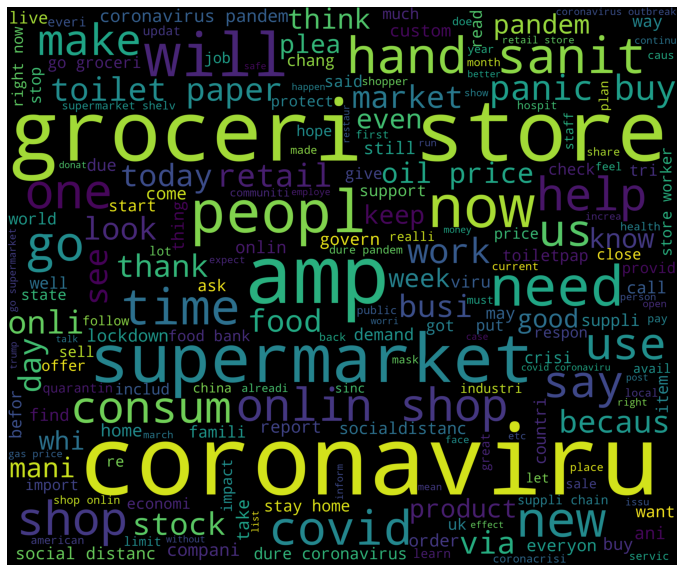

In [32]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# y_train_n = to_categorical(y_train_n)
# token = Tokenizer(oov_token="<OOV>")
# token.fit_on_texts(x_train_n)
# word_index = token.word_index
# seq = token.texts_to_sequences(x_train_n)
# train_padding = pad_sequences(seq , maxlen = 50 , padding = 'pre')
# train_padding.shape

## Algoritmo e teste

### Tokenização

In [33]:
token = Tokenizer(oov_token="<OOV>")
token.fit_on_texts(X)
word_index = token.word_index
seq = token.texts_to_sequences(X)
train_padding = pad_sequences(seq , maxlen = 50 , padding = 'pre')
train_padding.shape

(41157, 50)

### Camada de Embedding e Dimensão dos vetores 


In [41]:
EMBEDDING_DIM = 50
model = Sequential()
model.add(Embedding(40000, EMBEDDING_DIM, input_length=train_padding.shape[1]))
model.add(Dropout(0.2))
#model.add(LSTM(128, dropout=0.2,return_sequences=True))
#model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Reshape([-1]))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 50)            2000000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 2500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                80032     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 165       
Total params: 2,080,197
Trainable params: 2,080,197
Non-trainable params: 0
____________________________________________

In [42]:
epochs = 4
batch_size = 64
model.fit(train_padding, y, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.2)

Train on 32925 samples, validate on 8232 samples
Epoch 1/4
32925/32925 [==============================] - 16s 478us/step - loss: 1.3013 - accuracy: 0.4311 - val_loss: 0.9978 - val_accuracy: 0.5985
Epoch 2/4
32925/32925 [==============================] - 15s 469us/step - loss: 0.7961 - accuracy: 0.7044 - val_loss: 0.9318 - val_accuracy: 0.6390
Epoch 3/4
32925/32925 [==============================] - 15s 466us/step - loss: 0.4761 - accuracy: 0.8452 - val_loss: 1.0541 - val_accuracy: 0.6053
Epoch 4/4
32925/32925 [==============================] - 15s 463us/step - loss: 0.2553 - accuracy: 0.9208 - val_loss: 1.2478 - val_accuracy: 0.5801


In [44]:
 os.mkdir('./model')

In [45]:
"""Salvando o modelo treinado"""

model.save('./model/twitterUSAirline.h5')

### Teste

In [58]:
new = ['I love you so much']
    
seq = token.texts_to_sequences(new)
padded = sequence.pad_sequences(seq, maxlen=50)
pred = model.predict(padded)
classes  = np.argmax(pred , axis = -1)
dict_sentiment = {1 : 'Negative' , 2 : 'Neutral' , 3 : 'Positive', 4 : 'Extremely Positive', 0 : 'Extremely Negative'}


print(f'{new} : {dict_sentiment[int(classes)]}')

['I love you so much'] : Extremely Positive


### Utilizando o dataset de treino para inferir e verificar como ficou o modelo que foi treinado utilizando RN para NPL.

In [61]:
data = pd.read_csv('Corona_NLP_test.csv', engine ='python')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [70]:
test = data[['OriginalTweet']]
test.head()

,OriginalTweet
0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...
4,#toiletpaper #dunnypaper #coronavirus #coronav...
